In [1]:
!git clone https://github.com/usmanweb/Codes.git

Cloning into 'Codes'...
remote: Enumerating objects: 10406, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 10406 (delta 43), reused 119 (delta 39), pack-reused 10283
Receiving objects: 100% (10406/10406), 423.92 MiB | 17.74 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Updating files: 100% (10286/10286), done.


In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet101
from keras.applications.resnet import ResNet152
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import ResNet101V2
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import DenseNet201
from keras.activations import softmax, relu, sigmoid
from keras.optimizers.legacy import SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau,CSVLogger, EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
from random import shuffle
import random
import glob
from skimage.transform import resize

#from PIL import Image
import os
#from model import *

from collections import defaultdict
import itertools
from tqdm import tqdm
import time
import shutil
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping: no known devices.


In [ ]:
model_name = 'VGG16_Jan2020'
num_classes = 14

In [ ]:
def batch_generator(data_X, data_y, batch_size):
    indexes = np.array(range(len(data_y)))
    n = len(indexes)
    while True:
        batch_start = 0
        batch_end = batch_size
        np.random.shuffle(indexes)
        while batch_start < n:
            index = []
            batch_y = []
            y = []
            index = indexes[batch_start:batch_end]
            batch_x = np.array([data_X[i] for i in index])
            batch_y = np.array([data_y[i] for i in index])
            yield batch_x, batch_y
            batch_start += batch_size
            batch_end += batch_size
            if (batch_end>len(data_y)):
                batch_end = len(data_y)

In [ ]:
def read_landUse(dataset_path, im_type):
    import glob
    paths_X = []
    labels = []
    i = 0
    folders = sorted(os.listdir(dataset_path))
    for folder in folders:
        temp = sorted (glob.glob(os.path.join(dataset_path,folder+'/*'+im_type)))
        for k in range(len(temp)):
            labels.append (i)
        paths_X += temp
        i += 1

    if(len(paths_X)==0):
        print ('Dataset could not found. Please provide correct path.')
    return paths_X, labels

In [ ]:
dataset_path = 'Codes/KilnNet/Dataset/train/'
paths, labels = read_landUse(dataset_path, '[(.png)(.jpg)]')
images = np.array([cv2.imread(image_name) for image_name in paths])

In [ ]:
X_train = images
y_train = to_categorical(labels, num_classes)
#X, y = load_dataset(dataset_path)
print ('Size of dataset:', len(y_train))

Size of dataset: 9227


In [ ]:
dataset_path_val = 'Codes/KilnNet/Dataset/val/'
paths_val, labels_val = read_landUse(dataset_path_val, '[(.png)(.jpg)]')
X_val =  np.array([cv2.imread(image_name) for image_name in paths_val])
y_val = to_categorical(labels_val, num_classes)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2)
print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)

(816, 256, 256, 3) (204, 256, 256, 3) (816, 14) (204, 14)


Display dataset stats

0 ground 1127
1 roads 635
2 parks 623
3 grass 630
4 houses 633
5 ponds 638
6 densetrees 635
7 farms 634
8 tennis 524
9 kiln 629
10 blackfarms 650
11 mosque 620
12 oiltanks 632
13 parking 617


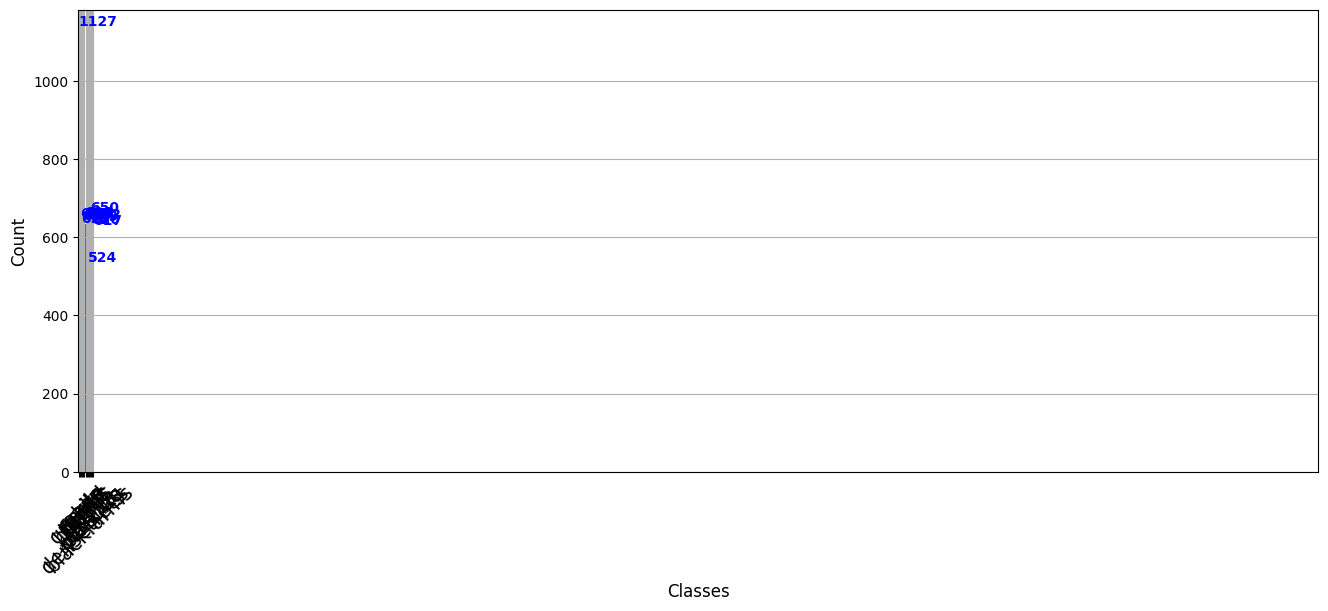

In [ ]:
folders = os.listdir(dataset_path)
names, counts = [], []
for i, folder in enumerate(folders):
    dir_path = os.path.join(dataset_path, folder)
    images = os.listdir(dir_path)
    names.append(folder)
    counts.append(len(images))
    print(i, folder, len(images))
df = pd.DataFrame(data={'Name': names, 'Count': counts})
ax = df.plot(kind='bar', xticks=counts, grid=True, legend=False, figsize=(16,6))
ax.set_xlabel('Classes', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.xticks(np.arange(len(names)), names, rotation=45, fontsize=15)
for i, v in enumerate(counts):
    ax.text(i-.18, v+15, str(v), color='blue', fontweight='bold')
plt.show()

In [ ]:
batch_size = 10
train_gen = batch_generator(X_train, y_train, batch_size)
val_gen = batch_generator(X_val, y_val, batch_size)
#test_gen = batch_generator(X_test, y_test, batch_size)

In [ ]:
input_shape=(256,256,3)
model= VGG16(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#model= VGG19(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#model= ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#= ResNet101(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#model= ResNet152(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#model= ResNet50V2(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#model= ResNet101V2(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
# model= ResNet152V2(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#model= InceptionResNetV2(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#model= InceptionV3(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#model= DenseNet121(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#model= DenseNet169(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#model= DenseNet201(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#model =InceptionResNetV2(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
#model = resNet(input_shape, num_classes, model_type='resnet_152')
#model.load_weights('WEIGHTS/'+model_name+'.h5')

### model_vgg16.layers[-1].activation = relu

### idx_of_layer_to_change = -1
#model.layers[idx_of_layer_to_change].activation = activations.softmax
#model = utils.apply_modifications(model)

#model_vgg16.layers[-1].activation = relu
# # FINE TUNING HERE
# top_model = Sequential()
# top_model.add(Dense(input_shape=model.layers[-2].output_shape, units=num_classes, rnel
# kernel_initializer="he_normal", activation="softmax"))

# model.layers.pop()
# model.outputs = [model.layers[-1].output]
# model.layers[-1].outbound_nodes = []

# model = Model(inputs=model.inputs, outputs=top_model(model.outputs[0]))
# # for layer in model.layers[:-1]:
# #     layer.trainable = False
#model.load_weights('WEIGHTS/'+model_name+'.h5')

model.summary()
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# plot_model(model, to_file='model.png')


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
class_weights = {0: 629/650,
                 1: 629/635,
                 2: 629/634,
                 3: 629/630,
                 4: 629/629,
                 5: 629/633,
                 6: 629/629,
                 7: 629/620,
                 8: 629/632,
                 9: 629/617,
                 10: 629/623,
                 11:629/638,
                 12:629/635,
                 13:629/524
                }

Train ResNet-152 network using "fit_generator"

In [ ]:
checkpoint = ModelCheckpoint('WEIGHTS/'+model_name+'.h5', monitor='val_loss', verbose=2, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='EVENTS/', batch_size=batch_size, write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.00001)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='auto')
cvslogger = keras.callbacks.CSVLogger('WEIGHTS/'+model_name+'.csv', separator=',', append=True)

nb_epoch = 200
callbacks = [checkpoint, reduce_lr, earlystop, cvslogger, tensorboard]
train_steps = int(len(y_train)//batch_size)
val_steps = int(len(y_val)//batch_size)
start_time = time.time()
history = model.fit_generator(train_gen, train_steps, epochs=nb_epoch, verbose=1,
                    max_queue_size=2, validation_data=val_gen,
                    validation_steps=val_steps, shuffle=True,
                    workers=1, use_multiprocessing= False,
                    initial_epoch=0, callbacks=callbacks, class_weight=class_weights)
print("Seconds: ", time.time() - start_time)
#model.fit(x=X[0:100], y=y[0:100], batch_size=64, epochs=2, verbose=1, callbacks=callbacks,
#          validation_split=0.2, shuffle=True,initial_epoch=0)


<ipython-input-19-a30530e29d69>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, train_steps, epochs=nb_epoch, verbose=1,


Epoch 1/200
 36/922 [>.............................] - ETA: 7:09:53 - loss: 2.8616 - accuracy: 0.0667

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
Total params: 112576 (439.75 KB)
Trainable params: 112576 (439.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1/1 [==============================] - 0s 168ms/step


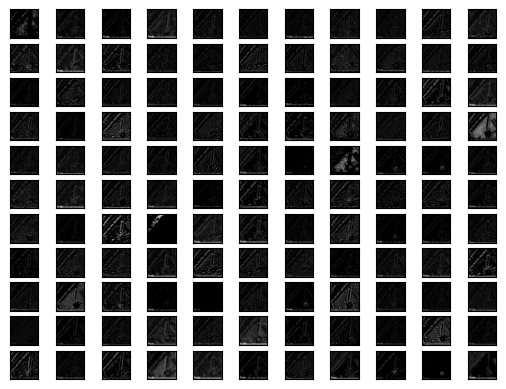

In [7]:
from matplotlib import pyplot
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
layer_output = model.get_layer('block2_conv1').output
# model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model = Model(inputs=model.inputs, outputs=layer_output)
model.summary()
# load the image with the required shape
img = load_img('/content/Codes/KilnNet/Dataset/train/parks/74.5291712482_31.5705141576.png', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 11
ix = 1
for _ in range(square):
  for _ in range(square):
 # specify subplot and turn of axis
    ax = pyplot.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
 # plot filter channel in grayscale
    pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1
# show the figure
pyplot.show()